<a href="https://colab.research.google.com/github/douglasmmachado/Battery_SoC/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
!pip install nnfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [134]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [135]:
df_data = pd.read_csv('https://raw.githubusercontent.com/douglasmmachado/Battery_SoC/main/1%20-%20NN/data.csv')

In [136]:
df_data.info()
df_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72832 entries, 0 to 72831
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   current_measured  72831 non-null  float64
 1   voltage_measured  72832 non-null  float64
 2   voc               72831 non-null  float64
 3   rint              72831 non-null  float64
 4   zeta              72831 non-null  float64
dtypes: float64(5)
memory usage: 2.8 MB


,current_measured,voltage_measured,voc,rint,zeta
59566,0.77745,3.7980,3.8453,0.060844,13.58500
26943,0.74969,3.1867,3.2318,0.060253,0.41562
13334,0.85621,3.7844,3.8358,0.060084,12.29600
61238,1.14370,3.8742,3.9439,0.060928,63.75200
36616,0.93639,3.8241,3.8807,0.060422,29.22300


<Axes: >

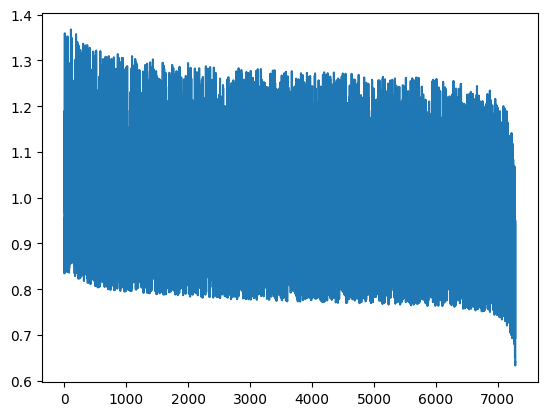

In [137]:
df_current_measured_plot = df_data.current_measured[0:7284]
df_current_measured_plot.plot()

<Axes: title={'center': 'Load voltage over time'}>

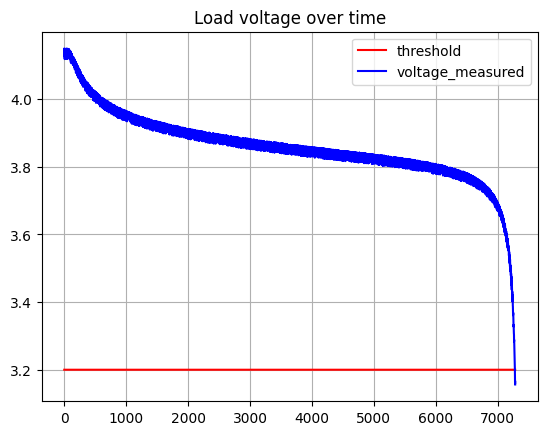

In [138]:
df_voltage_measured = df_data.voltage_measured[0:7284]
df_yline = pd.DataFrame([3.2 for x in range(len(df_voltage_measured))], columns=["threshold"]).plot(color='r')
df_voltage_measured.plot(title='Load voltage over time', grid=True, legend=True, color='b')

<Axes: title={'center': 'Open circuit voltage over time'}>

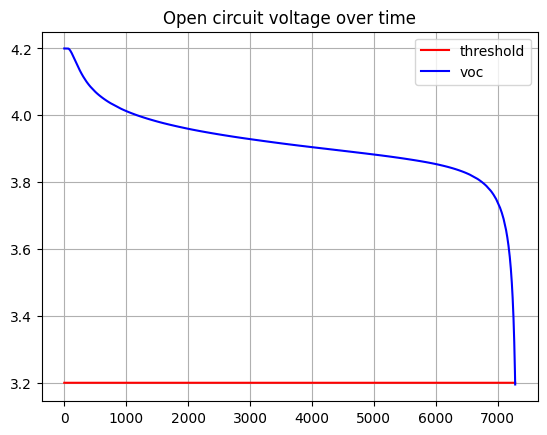

In [139]:
df_voc = df_data.voc[0:7284]
df_yline = pd.DataFrame([3.2 for x in range(len(df_voc))], columns=["threshold"]).plot(color='r')
df_voc.plot(title='Open circuit voltage over time', grid=True, legend=True, color='b')

<Axes: title={'center': 'State of charge over time'}>

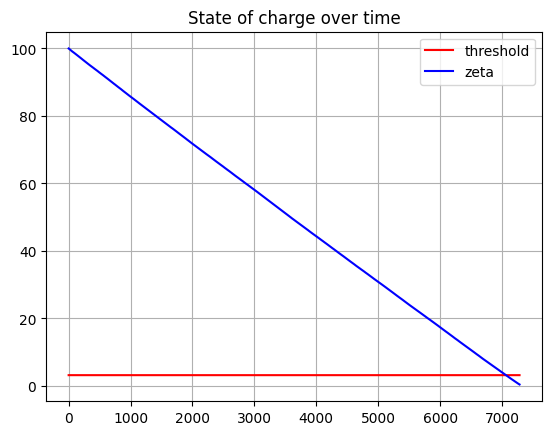

In [140]:
df_zeta = df_data.zeta[0:7284]
df_yline = pd.DataFrame([3.2 for x in range(len(df_zeta))], columns=["threshold"]).plot(color='r')
df_zeta.plot(title='State of charge over time', grid=True, legend=True, color='b')

In [141]:
X_train, X_test, y_train, y_test = train_test_split(df_data[['current_measured','voltage_measured']],df_data[['voc','rint','zeta']], train_size=0.5)

#Model Functions


In [163]:
#Modifying the Layer dense 

class Layer_Dense:

  def __init__(self, n_inputs, n_neurons,
               weight_regularizer_l1 = 0,
               weight_regularizer_l2 = 0,
               bias_regularizer_l1 = 0,
               bias_regularizer_l2 = 0):

    self.weights = 0.1 * np.random.randn(n_inputs,n_neurons) #Changed the multiplication of 0.01 to 0.1
    self.biases = np.zeros((1, n_neurons))

    self.weight_regularizer_l1 = weight_regularizer_l1
    self.weight_regularizer_l2 = weight_regularizer_l2

    self.bias_regularizer_l1 = bias_regularizer_l1
    self.bias_regularizer_l2 = bias_regularizer_l2

  def forward(self, inputs, training):
    self.inputs = inputs
    self.output = np.dot(inputs, self.weights) + self.biases

  def backward(self, dvalues):
    self.dweights = np.dot(self.inputs.T, dvalues)
    self.dbiases = np.sum(dvalues, axis=0, keepdims = True)

    #L1 on weights
    if self.weight_regularizer_l1 > 0:
      dL1 = np.ones_like(self.weights)
      dL1[self.weights < 0] = -1
      self.dweights += self.weight_regularizer_l1 * dL1
    
    #L2 on weights
    if self.weight_regularizer_l2 > 0:
      self.dweights += 2 * self.weight_regularizer_l2 * self.weights
    
    #L1 on biases
    if self.bias_regularizer_l1 > 0 :
      dL1 = np.ones_like(self.biases)
      dL1[self.biases < 0] = -1
      self.dbiases += self.bias_regularizer_l1 * dL1
    
    #L2 on biases
    if self.bias_regularizer_l2 > 0:
      self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

    self.dinputs = np.dot(dvalues, self.weights.T)


In [161]:
class Layer_Dropout:

  def __init__(self, rate):

    self.rate = 1 - rate

  def forward(self, inputs):
    self. inputs = inputs
    if not training:
      self.output = inputs.copy()
      return

    self.binary_mask = np.random.binomial(1, self.rate, size = inputs.shape) / self.rate
    self.output = inputs * self.binary_mask

  def backward(self, dvalues):
    self.dinputs = dvalues * self.binary_mask
  

In [144]:
class Layer_input:
  def forward(self, inputs, training):
    self.output = inputs

#Optmizer ADAM

In [145]:
class Optimizer_Adam:

  def __init__(self, learning_rate = 0.001,
               decay = 0.,
               epsilon = 1e-7,
               beta_1 = 0.9,
               beta_2 = 0.999):
    
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.beta_1 = beta_1
    self.beta_2 = beta_2
  
  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))


  def update_params(self, layer):
    if not hasattr(layer, 'weight_cache'):
      layer.weight_momentums = np.zeros_like(layer.weights)
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_momentums = np.zeros_like(layer.biases)
      layer.bias_cache = np.zeros_like(layer.biases)
    
    layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
    layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases    
    
    weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
    bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

    layer.weight_cache = self.beta_2 * layer.weight_cache + (1- self.beta_2) * layer.dweights**2
    layer.bias_cache = self.beta_2 * layer.bias_cache + (1- self.beta_2) * layer.dbiases**2

    weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
    bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

    layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
    layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

  def post_update_params(self):
    self.iterations += 1

#Loss

In [146]:
class Loss:
  
  def regularization_loss(self):
    
    regularization_loss = 0

    for layer in self.trainable_layers:
      if layer.weight_regularizer_l1 > 0:
        regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

      if layer.weight_regularizer_l2 > 0:
        regularization_loss += layer.weight_regularizer_l2 * np.sum(np.abs(layer.weights))

      if layer.bias_regularizer_l1 > 0:
        regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
      
      if layer.bias_regularizer_l2 > 0:
        regularization_loss += layer.bias_regularizer_l2 * np.sum(np.abs(layer.biases))
      
    return regularization_loss
  
  def remember_trainable_layers(self, trainable_layers):
    self.trainable_layers = trainable_layers

  def calculate(self, output, y, *, include_regularization=False):
    sample_losses = self.forward(output, y)
    data_loss = np.mean(sample_losses)
    if not include_regularization:
      return data_loss
      
    return data_loss, self.regularization_loss()

In [147]:
# Mean Absolute Squared Erros Loss

class Loss_MeanAbsoluteError(Loss): #L1 Loss

  def forward(self, y_pred, y_true):
    sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
    return sample_losses

  def backward(self, dvalues, y_true):
    samples = len(dvalues)
    outputs = len(dvalues[0])
    self.dinputs = np.sign(y_true - dvalues) / outputs
    self.dinputs = self.dinputs / samples


In [148]:
# Mean Squared Erros Loss

class Loss_MeanSquaredError(Loss): #L2 loss

  def forward(self, y_pred, y_true):
    sample_losses = np.mean((y_true - y_pred)**2,axis = -1)
    return sample_losses

  def backward(self, dvalues, y_true):
    samples = len(dvalues)
    outputs = len(dvalues[0])
    self.dinputs = -2 * (y_true - dvalues) / outputs
    self.dinputs = self.dinputs / samples


In [149]:
class Loss_CategoricalCrossEntropy(Loss):

  def forward(self, y_pred, y_true):
    
    samples = len(y_pred)

    # Clip data to prevent division by 0
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

    # Probabilities for target values
    # Only if categorical labels
    if len(y_true.shape) == 1:
      correct_confidences = y_pred_clipped[range(samples),y_true]
      
    elif len(y_true.shape) == 2:
      correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

    negative_log_likelihoods = -np.log(correct_confidences)
    return negative_log_likelihoods

  def backward(self, dvalues, y_true):

    samples = len(dvalues)

    labels = len(dvalues[0])

    if len(y_true.shape) == 1:

      y_true = np.eye(labels)[y_true]

    self.dinputs = -y_true / dvalues
    
    self.dinputs = self.dinputs / samples

In [150]:
class Loss_BinaryCrossentropy(Loss):
  
  def forward(self, y_pred, y_true):

    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
    sample_losses = -(y_true * np.log(y_pred_clipped) + (1-y_true)*np.log(1 - y_pred_clipped))
    sample_losses = np.mean(sample_losses,axis=-1)
    return sample_losses
  
  def backward(self, dvalues, y_true):
    samples = len(dvalues)
    outputs = len(dvalues[0])
    clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
    self.dinputs = -(y_true / clipped_dvalues - (1-y_true)/(1-clipped_dvalues)) / outputs
    self.dinputs = self.dinputs/samples

#Helpers functions


In [151]:
#Linear activation

class Activation_Linear:

  def forward(self, inputs, training):
    self.inputs = inputs
    self.output = inputs
  
  def backward(self, dvalues):
    self.dinputs = dvalues.copy()
  
  def predictions(self, outputs):
    return outputs

In [152]:
class Activation_SoftMax:
  def forward(self, inputs, training):
    
    self.inputs = inputs

    exp_values = np.exp(inputs - np.max(inputs,axis=1, keepdims=True))

    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

    self.output = probabilities

  def backward(self, dvalues):

    self.dinputs = np.empty_like(dvalues)

    for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
      
      single_output = single_output.reshape(-1,1)
      
      jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
      
      self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

  def predictions(self, outputs):
    return np.argmax(outputs, axis=1)

In [153]:
class Activation_ReLU:

  def forward(self, inputs, training):
    self.inputs = inputs
    self.output = np.maximum(0,inputs)
  
  def backward(self, dvalues):
    self.dinputs = dvalues.copy()
    self.dinputs[self.inputs <= 0 ] = 0
  
  def predictions(self, outputs):
    return outputs

In [154]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
  def backward(self, dvalues, y_true):
    samples = len(dvalues)
    if len(y_true.shape) == 2:
      y_true = np.argmax(y_true,axis=1)
    self.dinputs = dvalues.copy()
    self.dinputs[range(samples), y_true] -= 1
    self.dinputs = self.dinputs / samples

In [155]:
class Activation_Sigmoid:
  def forward(self, inputs, training):
    self.inputs = inputs
    self.output = 1 / (1 + np.exp(-inputs))

  def backward(self, dvalues):
    self.dinputs = dvalues * (1- self.output) * self.output
  
  def prediction(self, outputs):
    return (outputs > 0.5) * 1

#Accuracy

In [156]:
class Accuracy:

  def calculate(self, predictions, y):
     comparisons = self.compare(predictions, y)
     accuracy = np.mean(comparisons)
     return accuracy

In [157]:
class Accuracy_Categorical(Accuracy):
  def init(self, y):
    pass
  
  def compare(self, predictions, y):
    if len(y.shape) == 2:
      y = np.argmax(y, axis=1)
    return predictions == y

In [158]:
class Accuracy_Regression(Accuracy):
  
  def __init__(self):
    self.precision = None
  
  def init(self, y, reinit=False):
    if self.precision is None or reinit:
      self.precision = np.std(y) / 250
    
  def compare(self, predictions, y):
    return np.absolute(predictions - y) < self.precision


#MODEL

In [159]:
class Model:
  def __init__(self):
    self.layers = []
    self.softmax_classifier_output = None

  def add(self, layer):
    self.layers.append(layer)

  def settings(self, *, loss, optimizer, accuracy):
    self.loss = loss
    self.optimizer = optimizer
    self.accuracy = accuracy
    
  def finalize(self):
    self.input_layer = Layer_input()
    layer_count = len(self.layers)

    self.trainable_layers = []

    for i in range(layer_count):
      if i == 0:
        self.layers[i].prev = self.input_layer
        self.layers[i].next = self.layers[i+1]
      elif i < layer_count - 1:
        self.layers[i].prev = self.layers[i-1]
        self.layers[i].next = self.layers[i+1]
      else:
        self.layers[i].prev = self.layers[i-1]
        self.layers[i].next = self.loss
        self.output_layer_activation = self.layers[i]

      if hasattr(self.layers[i], 'weights'):
        self.trainable_layers.append(self.layers[i])
      
      self.loss.remember_trainable_layers(self.trainable_layers)
    
    if isinstance(self.layers[-1], Activation_SoftMax) and \
      isinstance(self.loss, Loss_CategoricalCrossEntropy):
      self.softmax_classifier_output = Activation_Softmax_Loss_CategoricalCrossentropy()


  def train(self, X, y, *, epochs=1, print_every=1, validation_data=None):

    self.accuracy.init(y)

    for epoch in range(1, epochs+1):
      output = self.forward(X, training=True)

      data_loss, regularization_loss = self.loss.calculate(output, y, include_regularization=True)

      loss = data_loss + regularization_loss
      predictions = self.output_layer_activation.predictions(output)
      accuracy = self.accuracy.calculate(predictions, y)

      self.backward(output, y)

      self.optimizer.pre_update_params()

      for layer in self.trainable_layers:
        self.optimizer.update_params(layer)

      self.optimizer.post_update_params()

      if not epoch % print_every:
        print(f'epoch: {epoch} ' +
          f'loss: {loss:.3f} ' +
          f'acc: {accuracy:.3f} ' +
          f'data_los: {data_loss:.3f} ' +
          f'reg_los: {regularization_loss:.3f} ' + 
          f'lr: {self.optimizer.current_learning_rate:.3f}')
      
    if validation_data is not None:
      X_val, y_val = validation_data
      output = self.forward(X_val, training=False)
      loss = self.loss.calculate(output, y_val)
      predictions = self.output_layer_activation.predictions(output)
      accuracy = self.accuracy.calculate(predictions, y_val)
      print(f'validation, '+
            f'acc: {accuracy:.3f}'+
            f'loss: {loss:.3f}')

  def forward(self, X, training):
    self.input_layer.forward(X, training)

    for layer in self.layers:
      layer.forward(layer.prev.output, training)

    return layer.output

  def backward(self, output, y):
    if self.softmax_classifier_output is not None:
      self.softmax_classifier_output.backward(output, y)
      self.layers[-1].dinputs = self.softmax_classifier_output.dinputs
      for layer in reversed(self.layers[:-1]):
        layer.backward(layer.next.dinputs)
      return
    self.loss.backward(output,y)
    for layer in reversed(self.layers):
      layer.backward(layer.next.dinputs)


In [165]:
import nnfs
from nnfs.datasets import sine_data
nnfs.init()
X, y = sine_data()


model = Model()


model.add(Layer_Dense(1,64))
model.add(Activation_ReLU())
model.add(Layer_Dense(64,64))
model.add(Activation_ReLU())
model.add(Layer_Dense(64,64))
model.add(Layer_Dense(64,1))
model.add(Activation_Linear())

model.settings(loss=Loss_MeanSquaredError(),
               optimizer = Optimizer_Adam(learning_rate = 0.005, decay = 1e-3),
               accuracy = Accuracy_Regression()
          )

model.finalize()

model.train(X, y, epochs=10000, print_every=100)

epoch: 100 loss: 0.013 acc: 0.026 data_los: 0.013 reg_los: 0.000 lr: 0.005
epoch: 200 loss: 0.000 acc: 0.064 data_los: 0.000 reg_los: 0.000 lr: 0.004
epoch: 300 loss: 0.000 acc: 0.006 data_los: 0.000 reg_los: 0.000 lr: 0.004
epoch: 400 loss: 0.000 acc: 0.444 data_los: 0.000 reg_los: 0.000 lr: 0.004
epoch: 500 loss: 0.000 acc: 0.462 data_los: 0.000 reg_los: 0.000 lr: 0.003
epoch: 600 loss: 0.000 acc: 0.492 data_los: 0.000 reg_los: 0.000 lr: 0.003
epoch: 700 loss: 0.000 acc: 0.523 data_los: 0.000 reg_los: 0.000 lr: 0.003
epoch: 800 loss: 0.000 acc: 0.522 data_los: 0.000 reg_los: 0.000 lr: 0.003


KeyboardInterrupt: ignored